In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages', '/fh/fast/bloom_j/computational_notebooks/dbacsik/2019/flu_pdmH1N1_barcode_hashing/notebooks']); import pickle; snakemake = pickle.loads(b'\x80\x04\x95\x84@\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8c]results/viral_progeny/revised_progeny_sequencing_bcTroubleShooting_viral_bc_in_progeny.csv.gz\x94\x8c3notebooks/process_viral_barcode_replicates.py.ipynb\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\x17viral_bc_in_progeny_csv\x94K\x00N\x86\x94\x8c\x08notebook\x94K\x01N\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh\x15\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(h\x1b)}\x94\x8c\x05_name\x94h\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bh\x0fh\nh\x11h\x0bub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94(\x8cbresults/viral_progeny/revised_progeny_sequencing_bcTroubleShooting_viral_bc_in_progeny_freq.csv.gz\x94\x8cZresults/viral_progeny/revised_progeny_sequencing_bcTroubleShooting_viral_bc_replicates.pdf\x94e}\x94(h\r}\x94(\x8c\x1cviral_bc_in_progeny_freq_csv\x94K\x00N\x86\x94\x8c\x04plot\x94K\x01N\x86\x94uh\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bh-h)h/h*ub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94}\x94(h\r}\x94h\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94\x8c,revised_progeny_sequencing_bcTroubleShooting\x94a}\x94(h\r}\x94\x8c\x04expt\x94K\x00N\x86\x94sh\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94b\x8c\x04expt\x94hMub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01e}\x94(h\r}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94uh\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bhcK\x01heK\x01ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8c`results/logs/process_viral_barcode_replicates_revised_progeny_sequencing_bcTroubleShooting.ipynb\x94a}\x94(h\r}\x94h\x11K\x00N\x86\x94sh\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bh\x11htub\x8c\x06config\x94}\x94(\x8c\x08max_cpus\x94K\x10\x8c\x07log_dir\x94\x8c\x0cresults/logs\x94\x8c\x0cfastq10x_dir\x94\x8c\x10results/fastq10x\x94\x8c\npacbio_dir\x94\x8c\x0eresults/pacbio\x94\x8c\x0emkfastq10x_dir\x94\x8c\x1fresults/fastq10x/mkfastq_output\x94\x8c\ngenome_dir\x94\x8c\x0fresults/genomes\x94\x8c\trefgenome\x94\x8c\x19results/genomes/refgenome\x94\x8c\x14aligned_fastq10x_dir\x94\x8c\x18results/aligned_fastq10x\x94\x8c\x12viral_fastq10x_dir\x94\x8c\x16results/viral_fastq10x\x94\x8c\x1bviral_tags_bcs_in_cells_dir\x94\x8c\x1fresults/viral_tags_bcs_in_cells\x94\x8c\x11viral_progeny_dir\x94\x8c\x15results/viral_progeny\x94\x8c\x13align_and_parse_dir\x94\x8c#results/pacbio/CA09_align_and_parse\x94\x8c\x0fcell_genome_ftp\x94\x8cmftp://ftp.ensembl.org/pub/release-98/fasta/canis_familiaris/dna/Canis_familiaris.CanFam3.1.dna.toplevel.fa.gz\x94\x8c\x0ccell_gtf_ftp\x94\x8c^ftp://ftp.ensembl.org/pub/release-98/gtf/canis_familiaris/Canis_familiaris.CanFam3.1.98.gtf.gz\x94\x8c\x0cviral_genome\x94\x8c!data/flu_sequences/flu-CA09.fasta\x94\x8c\tviral_gtf\x94\x8c\x1fdata/flu_sequences/flu-CA09.gtf\x94\x8c\rviral_genbank\x94\x8c\x1edata/flu_sequences/flu-CA09.gb\x94\x8c\x14viral_tag_identities\x94\x8c+data/flu_sequences/flu-CA09_viral_tags.yaml\x94\x8c\x0fviral_amplicons\x94\x8c.data/flu_sequences/pacbio_amplicons/fluCA09.gb\x94\x8c\x11amplicon_features\x94\x8c9data/flu_sequences/pacbio_amplicons/fluCA09_features.yaml\x94\x8c\x1eamplicon_linearization_primers\x94\x8c=data/flu_sequences/pacbio_amplicons/linearization_primers.tsv\x94\x8c\x15amplicon_to_reference\x94\x8c=data/flu_sequences/pacbio_amplicons/amplicon_to_reference.csv\x94\x8c\x0escoreGapNoncan\x94J\xfc\xff\xff\xff\x8c\x0cscoreGapGCAG\x94J\xfc\xff\xff\xff\x8c\x0cscoreGapATAC\x94J\xfc\xff\xff\xff\x8c\x14cb_whitelist_10x_url\x94\x8ckhttps://github.com/10XGenomics/cellranger/raw/master/lib/python/cellranger/barcodes/3M-february-2018.txt.gz\x94\x8c\x10cb_whitelist_10x\x94\x8c-results/aligned_fastq10x/cb_whitelist_10x.txt\x94\x8c\ncb_len_10x\x94K\x10\x8c\x0bumi_len_10x\x94K\x0c\x8c"infection_calling_by_viral_tag_fdr\x94G?\x1a6\xe2\xeb\x1cC-\x8c\x1dviral_barcode_upstream_length\x94K\x1c\x8c\x16viral_barcode_mismatch\x94K\x00\x8c\x12viral_barcode_minq\x94K\x1e\x8c\x0cviral_bc_fdr\x94G?\x1a6\xe2\xeb\x1cC-\x8c\x0eccs_min_length\x94K2\x8c\x0eccs_max_length\x94M\x88\x13\x8c\nccs_min_rq\x94G?\xef\xf7\xce\xd9\x16\x87+\x8c\x0bexperiments\x94}\x94(\x8c,scProgenyProduction_trial1_bcTroubleShooting\x94}\x94(\x8c\x0bdescription\x94\x8c\xe7Single-cell transcriptomics performed on low MOI-infected sample. Innoculum volumes based on `hashing_trial2` data. Loaded all collected cells from two 24-well wells, each infected with either wildtype or dblySn viral tag variants.\x94\x8c\tlab_notes\x94\x8c0https://benchling.com/s/etr-20lOO7l1FdEJJIpxV6vD\x94\x8c\rexpect_ncells\x94M\x10\'\x8c\x0eviral_barcodes\x94}\x94(\x8c\x07plasmid\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94\x8c\x08datetime\x94\x8c\x04date\x94\x93\x94C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x84/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcHA-WT_S1_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94\x8c\t2019-1216\x94\x8c\x84/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcNA-WT_S3_L001_R1_001.fastq.gz\x94ssu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x88/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcHA-dblSyn_S2_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x88/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcNA-dblSyn_S4_L001_R1_001.fastq.gz\x94ssuu\x8c\x06rescue\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x83/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/rescue-bcHA-WT_S5_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x83/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/rescue-bcNA-WT_S7_L001_R1_001.fastq.gz\x94ssu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/191223_M03100_0515_000000000-CTH55/Data/Intensities/BaseCalls/dblSyn-rescueTrial2-HA_S1_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/191223_M03100_0515_000000000-CTH55/Data/Intensities/BaseCalls/dblSyn-rescueTrial2-NA_S2_L001_R1_001.fastq.gz\x94ssuu\x8c\x0bsupernatant\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8a/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-WT-Sup-fluHA-A_S1_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8a/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-WT-Sup-fluHA-B_S2_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-WT-Sup-fluNA-A_S17_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-WT-Sup-fluNA-B_S18_L001_R1_001.fastq.gz\x94suu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8e/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-dblSyn-Sup-fluHA-A_S3_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8e/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-dblSyn-Sup-fluHA-B_S4_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8f/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-dblSyn-Sup-fluNA-A_S19_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8f/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-dblSyn-Sup-fluNA-B_S20_L001_R1_001.fastq.gz\x94suuu\x8c\x10second_infection\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x90/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-WT-SecondInf-fluHA-A_S5_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x90/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-WT-SecondInf-fluHA-B_S6_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x91/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-WT-SecondInf-fluNA-A_S21_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x91/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-WT-SecondInf-fluNA-B_S22_L001_R1_001.fastq.gz\x94suu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x94/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-dblSyn-SecondInf-fluHA-A_S7_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x94/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-dblSyn-SecondInf-fluHA-B_S8_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x95/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-dblSyn-SecondInf-fluNA-A_S23_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x95/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial1-dblSyn-SecondInf-fluNA-B_S24_L001_R1_001.fastq.gz\x94suuuuu\x8c,scProgenyProduction_trial2_bcTroubleShooting\x94}\x94(\x8c\x0bdescription\x94\x8c\xe7Single-cell transcriptomics performed on low MOI-infected sample. Innoculum volumes based on `hashing_trial2` data. Loaded all collected cells from two 24-well wells, each infected with either wildtype or dblySn viral tag variants.\x94\x8c\tlab_notes\x94\x8c0https://benchling.com/s/etr-73UD4Mx8uXn1xcxlV1ym\x94\x8c\rexpect_ncells\x94M\x10\'\x8c\x0eviral_barcodes\x94}\x94(\x8c\x07plasmid\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x84/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcHA-WT_S1_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94\x8c\t2019-1216\x94\x8c\x84/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcNA-WT_S3_L001_R1_001.fastq.gz\x94ssu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x88/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcHA-dblSyn_S2_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x88/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcNA-dblSyn_S4_L001_R1_001.fastq.gz\x94ssuu\x8c\x06rescue\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x83/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/rescue-bcHA-WT_S5_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x83/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/rescue-bcNA-WT_S7_L001_R1_001.fastq.gz\x94ssu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/191223_M03100_0515_000000000-CTH55/Data/Intensities/BaseCalls/dblSyn-rescueTrial2-HA_S1_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/191223_M03100_0515_000000000-CTH55/Data/Intensities/BaseCalls/dblSyn-rescueTrial2-NA_S2_L001_R1_001.fastq.gz\x94ssuu\x8c\x0bsupernatant\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8a/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-WT-Sup-fluHA-A_S9_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-WT-Sup-fluHA-B_S10_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-WT-Sup-fluNA-A_S25_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-WT-Sup-fluNA-B_S26_L001_R1_001.fastq.gz\x94suu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8f/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-dblSyn-Sup-fluHA-A_S11_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8f/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-dblSyn-Sup-fluHA-B_S12_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8f/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-dblSyn-Sup-fluNA-A_S27_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x8f/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-dblSyn-Sup-fluNA-B_S28_L001_R1_001.fastq.gz\x94suuu\x8c\x10second_infection\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x91/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-WT-SecondInf-fluHA-A_S13_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x91/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-WT-SecondInf-fluHA-B_S14_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x91/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-WT-SecondInf-fluNA-A_S29_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x91/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-WT-SecondInf-fluNA-B_S30_L001_R1_001.fastq.gz\x94suu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x95/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-dblSyn-SecondInf-fluHA-A_S15_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x95/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-dblSyn-SecondInf-fluHA-B_S16_L001_R1_001.fastq.gz\x94su\x8c\x05fluNA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x95/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-dblSyn-SecondInf-fluNA-A_S31_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe4\n\r\x94\x85\x94R\x94\x8c\x95/shared/ngs/illumina/bloom_lab/201013_M03100_0625_000000000-JB2KP/Data/Intensities/BaseCalls/Trial2-dblSyn-SecondInf-fluNA-B_S32_L001_R1_001.fastq.gz\x94suuuuu\x8c,revised_progeny_sequencing_bcTroubleShooting\x94}\x94(\x8c\x0bdescription\x94\x8ciNew version of progeny sequencing library prep. Adjusted annealing/extension parameters and plate layout.\x94\x8c\tlab_notes\x94\x8c0https://benchling.com/s/etr-D9bvVlLM3K5lSgeiCGhg\x94\x8c\rexpect_ncells\x94M\x10\'\x8c\x0eviral_barcodes\x94}\x94(\x8c\x07plasmid\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x84/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcHA-WT_S1_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94\x8c\t2019-1216\x94\x8c\x84/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcNA-WT_S3_L001_R1_001.fastq.gz\x94ssu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x88/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcHA-dblSyn_S2_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x88/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/plasmid-bcNA-dblSyn_S4_L001_R1_001.fastq.gz\x94ssuu\x8c\x06rescue\x94}\x94(\x8c\x02wt\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x83/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/rescue-bcHA-WT_S5_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x83/shared/ngs/illumina/bloom_lab/191206_M03100_0506_000000000-CNPGD/Data/Intensities/BaseCalls/rescue-bcNA-WT_S7_L001_R1_001.fastq.gz\x94ssu\x8c\x03syn\x94}\x94(\x8c\x05fluHA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/191223_M03100_0515_000000000-CTH55/Data/Intensities/BaseCalls/dblSyn-rescueTrial2-HA_S1_L001_R1_001.fastq.gz\x94ss\x8c\x05fluNA\x94}\x94\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe3\x0c\x10\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/191223_M03100_0515_000000000-CTH55/Data/Intensities/BaseCalls/dblSyn-rescueTrial2-NA_S2_L001_R1_001.fastq.gz\x94ssuu\x8c\x0bsupernatant\x94}\x94(\x8c\x02wt\x94}\x94\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe5\x02\x1a\x94\x85\x94R\x94\x8c\x8f/shared/ngs/illumina/bloom_lab/210226_M03100_0664_000000000-JG4MH/Data/Intensities/BaseCalls/PP-Bottleneck-HA-WT-Sup-B1_S1_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe5\x02\x1a\x94\x85\x94R\x94\x8c\x8f/shared/ngs/illumina/bloom_lab/210226_M03100_0664_000000000-JG4MH/Data/Intensities/BaseCalls/PP-Bottleneck-HA-WT-Sup-B2_S2_L001_R1_001.fastq.gz\x94sus\x8c\x03syn\x94}\x94\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe5\x02\x1a\x94\x85\x94R\x94\x8c\x90/shared/ngs/illumina/bloom_lab/210226_M03100_0664_000000000-JG4MH/Data/Intensities/BaseCalls/PP-Bottleneck-dblSyn-Sup-B1_S5_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe5\x02\x1a\x94\x85\x94R\x94\x8c\x90/shared/ngs/illumina/bloom_lab/210226_M03100_0664_000000000-JG4MH/Data/Intensities/BaseCalls/PP-Bottleneck-dblSyn-Sup-B2_S6_L001_R1_001.fastq.gz\x94susu\x8c\x10second_infection\x94}\x94(\x8c\x02wt\x94}\x94\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe5\x02\x1a\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/210226_M03100_0664_000000000-JG4MH/Data/Intensities/BaseCalls/PP-Bottleneck-WT-SI-B1_S3_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe5\x02\x1a\x94\x85\x94R\x94\x8c\x8b/shared/ngs/illumina/bloom_lab/210226_M03100_0664_000000000-JG4MH/Data/Intensities/BaseCalls/PP-Bottleneck-WT-SI-B2_S4_L001_R1_001.fastq.gz\x94sus\x8c\x03syn\x94}\x94\x8c\x05fluHA\x94}\x94(\x8c\x0breplicate_1\x94}\x94h\xd4C\x04\x07\xe5\x02\x1a\x94\x85\x94R\x94\x8c\x8f/shared/ngs/illumina/bloom_lab/210226_M03100_0664_000000000-JG4MH/Data/Intensities/BaseCalls/PP-Bottleneck-dblSyn-SI-B1_S7_L001_R1_001.fastq.gz\x94s\x8c\x0breplicate_2\x94}\x94h\xd4C\x04\x07\xe5\x02\x1a\x94\x85\x94R\x94\x8c\x8f/shared/ngs/illumina/bloom_lab/210226_M03100_0664_000000000-JG4MH/Data/Intensities/BaseCalls/PP-Bottleneck-dblSyn-SI-B2_S8_L001_R1_001.fastq.gz\x94susuuuuu\x8c\x04rule\x94\x8c process_viral_barcode_replicates\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8c[/fh/fast/bloom_j/computational_notebooks/dbacsik/2019/flu_pdmH1N1_barcode_hashing/notebooks\x94ub.'); from snakemake.logging import logger; logger.printshellcmds = False; import os; os.chdir('/fh/fast/bloom_j/computational_notebooks/dbacsik/2019/flu_pdmH1N1_barcode_hashing');
######## snakemake preamble end #########


# Process viral barcode replicates
This notebook plots the correlation between technical replicates of raw viral barcode sequencing data. Then, it calculates the mean frequency of each barcode and exports this value to a CSV. Data source is supernatant or second infection.

Import Python modules:

In [2]:
import gzip
import itertools
import random

from IPython.display import display

from dms_variants.constants import CBPALETTE

import editdistance

import numpy as np

import pandas as pd

import plotnine as p9

Hardcode variables for now:

In [3]:
viral_bc_in_progeny_csv = snakemake.input.viral_bc_in_progeny_csv
viral_bc_in_progeny_freq_csv = snakemake.output.viral_bc_in_progeny_freq_csv
plot = snakemake.output.plot
expt = snakemake.wildcards.expt

Load viral barcode counts and pivot dataframe so replicates in two columns.

In [4]:
viral_bc = pd.read_csv(gzip.open(viral_bc_in_progeny_csv))
viral_bc = pd.merge(viral_bc,
                    (viral_bc
                     .groupby(['source',
                               'tag',
                               'gene',
                               'replicate'])
                     .sum()
                     .reset_index()),
                    on=['source', 'tag', 'gene', 'replicate'],
                    suffixes=('_barcode', '_total'))
viral_bc['freq'] = (viral_bc['count_barcode'] /
                    viral_bc['count_total'])
display(viral_bc)

,source,tag,gene,replicate,barcode,count_barcode,count_total,freq
0,plasmid,syn,fluHA,replicate_1,GAGTAAAATTCCTACT,14,1032246,1.356266e-05
1,plasmid,syn,fluHA,replicate_1,AATAATGAACAATGAC,13,1032246,1.259390e-05
2,plasmid,syn,fluHA,replicate_1,ACAGCATAGAAAACGC,13,1032246,1.259390e-05
3,plasmid,syn,fluHA,replicate_1,ATATGACTAGAGGAAC,13,1032246,1.259390e-05
4,plasmid,syn,fluHA,replicate_1,TACCACAAAAAAATAA,13,1032246,1.259390e-05
...,...,...,...,...,...,...,...,...
4719992,supernatant,wt,fluHA,replicate_2,TTTTTGAGGACTCGTT,1,1377533,7.259354e-07
4719993,supernatant,wt,fluHA,replicate_2,TTTTTGTATAGACTCA,1,1377533,7.259354e-07
4719994,supernatant,wt,fluHA,replicate_2,TTTTTGTATAGAGTCC,1,1377533,7.259354e-07
4719995,supernatant,wt,fluHA,replicate_2,TTTTTGTGTTACTTCG,1,1377533,7.259354e-07


### Plots
Set theme for plots.

In [5]:
p9.theme_set(p9.theme_classic())

Plot number of barcodes identified for each sample:

,source,tag,gene,replicate,n_unique_barcodes
0,plasmid,syn,fluHA,replicate_1,957747
1,plasmid,syn,fluNA,replicate_1,1010667
2,plasmid,wt,fluHA,replicate_1,970857
3,plasmid,wt,fluNA,replicate_1,889670
4,rescue,syn,fluHA,replicate_1,94301
5,rescue,syn,fluNA,replicate_1,94570
6,rescue,wt,fluHA,replicate_1,289140
7,rescue,wt,fluNA,replicate_1,224097
8,second_infection,syn,fluHA,replicate_1,23933
9,second_infection,syn,fluHA,replicate_2,26555


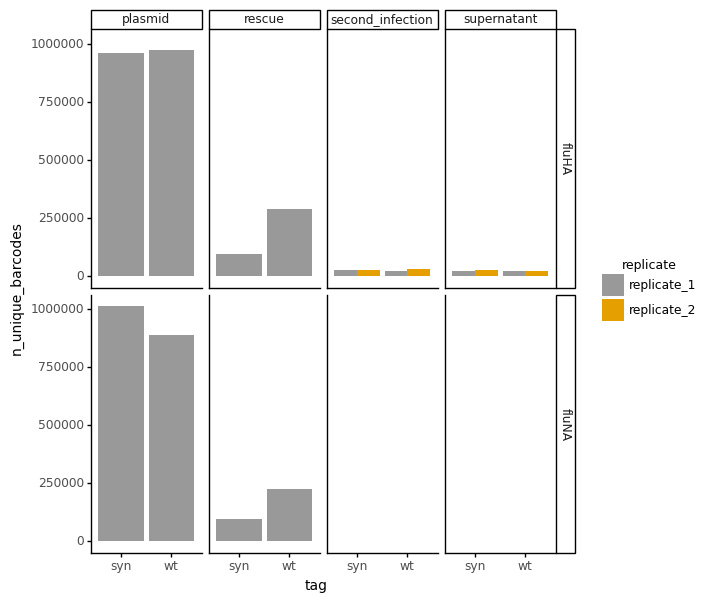

<ggplot: (8769349110989)>

In [6]:
n_barcodes_df = (viral_bc
                 .groupby(['source', 'tag', 'gene', 'replicate'])['barcode']
                 .nunique()
                 .reset_index()
                 .rename(columns={'barcode': 'n_unique_barcodes'}))

display(n_barcodes_df)

fig = (p9.ggplot(n_barcodes_df, p9.aes(x='tag',
                                       y='n_unique_barcodes',
                                       fill='replicate')) +
       p9.geom_bar(stat='identity', position='position_dodge') +
       p9.facet_grid('gene~source') +
       p9.theme(figure_size=(3*n_barcodes_df['gene'].nunique(),
                             1.7*n_barcodes_df['source'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
fig

Plot histogram for each sample:

In [ ]:
fig = (p9.ggplot(viral_bc, p9.aes(x='freq', fill='replicate')) +
       p9.geom_histogram(bins=100) +
       p9.facet_grid('gene+tag~source') +
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(3*viral_bc['source'].nunique(),
                             2*viral_bc['gene'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.ylab('n_barcodes') +
       p9.scale_fill_manual(CBPALETTE[0:]))
fig

Plot number of barcodes shared across tags:

In [ ]:
shared_tags = (viral_bc
               .groupby(['source',
                         'gene',
                         'barcode'])
               .agg({'tag': lambda x: ' and '.join(sorted(set(x)))})
               .rename(columns={'tag': 'tags_present'})
               .reset_index())

display(shared_tags)


fig = (p9.ggplot(shared_tags,
                 p9.aes(x='gene',
                        fill='tags_present')) +
       p9.geom_bar(stat='count') +
       p9.ggtitle(f'barcodes identified in each tag for {expt}') +
       p9.ylab('n_barcodes') +
       p9.coord_flip() +
       p9.facet_grid('source~') +
       p9.theme(figure_size=(7,
                             2*shared_tags['source'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))

# show plot
fig

Plot **fraction** of reads shared across tags:

Plot barcode frequency by sharing:

In [ ]:
shared_tags_freq = pd.merge(viral_bc,
                            shared_tags,
                            on=['source', 'gene', 'barcode'])

display(shared_tags_freq)

fig = (p9.ggplot(shared_tags_freq, p9.aes(x='freq', fill='tags_present')) +
       p9.geom_histogram(bins=100) +
       p9.facet_grid('gene~source') +
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(3*viral_bc['source'].nunique(),
                             2*viral_bc['gene'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.ylab('n_barcodes') +
       p9.scale_fill_manual(CBPALETTE[0:]))
fig

Plot correlation of barcodes in supernatant and in second infection. Color by presence in each (or both) tags.

In [ ]:
tag_freqs = (shared_tags_freq
             .pivot_table(index=['gene',
                                 'tag',
                                 'barcode',
                                 'tags_present'],
                          columns=['source'],
                          values='freq',
                          aggfunc=np.mean)
             .fillna(0)
             .reset_index())

display(tag_freqs)

fig = (p9.ggplot(tag_freqs,
                 p9.aes(x='supernatant',
                        y='second_infection',
                        color='tags_present')) +
       p9.ggtitle(f'{expt}\n'
                  'barcode counts in supernatant '
                  'and second infection for shared libraries') +
       p9.geom_point(alpha=0.4) +
       p9.facet_grid('gene~tag') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.scale_color_manual(CBPALETTE[0:]))
fig

Plot frequencies of barcodes and color by which tag (or both) they are found in:

In [ ]:
tag_freqs = (shared_tags_freq
             .pivot_table(index=['source',
                                 'gene',
                                 'barcode',
                                 'tags_present'],
                          columns=['tag'],
                          values='freq',
                          aggfunc=np.mean)
             .fillna(0)
             .reset_index())

display(tag_freqs)

fig = (p9.ggplot(tag_freqs,
                 p9.aes(x='wt',
                        y='syn',
                        color='tags_present')) +
       p9.ggtitle(f'{expt}\n'
                  'barcode counts in wt and syn for shared libraries') +
       p9.geom_point() +
       p9.facet_grid('gene~source') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.scale_color_manual(CBPALETTE[1:]))
fig

Plot frequencies on barcodes that are found in both tags, colored by replicate:

In [ ]:
tag_freqs = (shared_tags_freq
             .query('tags_present == "syn and wt"')
             .pivot_table(index=['source',
                                 'gene',
                                 'barcode',
                                 'replicate'],
                          columns=['tag'],
                          values='freq')
             .fillna(0)
             .reset_index())

display(tag_freqs)

fig = (p9.ggplot(tag_freqs,
                 p9.aes(x='wt',
                        y='syn',
                        color='replicate')) +
       p9.ggtitle(f'{expt}\n'
                  'barcode counts in wt and syn for shared libraries') +
       p9.geom_point() +
       p9.facet_grid('gene~source') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.scale_color_manual(CBPALETTE[1:]))
fig

Plot correlation of technical replicates

In [ ]:
# Check that replicates fit hardcoded expectations
# replicate_names = ['replicate_1', 'replicate_2']
# n_replicates = len(replicate_names)
# for (_source, _tag, _gene), df in (viral_bc.groupby(['source',
#                                                      'tag',
#                                                      'gene'])):
#     assert set(df['replicate'].unique()) == set(replicate_names), \
#         f"Code assumes exactly {n_replicates} replicates per sample."

viral_bc_wide = (viral_bc
                 .pivot_table(index=['source',
                                     'tag',
                                     'gene',
                                     'barcode'],
                              columns='replicate',
                              values='freq')
                 .reset_index()
                 .fillna(0))

viral_bc_wide.columns = ['source',
                         'tag',
                         'gene',
                         'barcode',
                         'replicate_1_freq',
                         'replicate_2_freq']

viral_bc_wide['in_both'] = ((viral_bc_wide['replicate_1_freq'] > 0)
                            & (viral_bc_wide['replicate_2_freq'] > 0))

display(viral_bc_wide)

fig = (p9.ggplot(viral_bc_wide,
                 p9.aes(x='replicate_1_freq',
                        y='replicate_2_freq',
                        color='in_both')) +
       p9.ggtitle(f'viral barcode replicates for experiment {expt}') +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('source~gene+tag') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(3.5*viral_bc_wide['gene'].nunique(),
                             2*viral_bc_wide['source'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual([CBPALETTE[1], '#000000']))

# save plot
print(f"Saving plot to {plot}")
p9.ggsave(plot=fig, filename=plot, verbose=False)

# show plot
fig

Average frequencies and export CSV:

In [ ]:
viral_bc_wide['mean_freq'] = ((viral_bc_wide['replicate_1_freq']
                               + viral_bc_wide['replicate_2_freq'])
                              / 2)

viral_bc_wide.to_csv(viral_bc_in_progeny_freq_csv,
                     columns=['source',
                              'tag',
                              'gene',
                              'barcode',
                              'mean_freq'],
                     index=False)

Calculate and plot edit distance between observed barcodes:

In [ ]:
sample_size = 1000
records = []
for (source, tag, gene), df in (viral_bc
                                .groupby(['source',
                                          'tag',
                                          'gene'])):
    print(f'Calculating hamming distance for {source} {tag} {gene}.'
          f'\n\tThere are {df["barcode"].nunique()} '
          'unique barcodes in dataset.'
          f'\n\tSampling {sample_size} barcodes for distribution.')
    sample = random.sample(list(df['barcode'].unique()), sample_size)
    for bc_pair in itertools.combinations(sample, 2):
        records.append((source,
                        tag,
                        gene,
                        bc_pair[0],
                        bc_pair[1],
                        editdistance.eval(bc_pair[0], bc_pair[1])))

pairs_df = pd.DataFrame.from_records(records)
pairs_df.columns = ['source',
                    'tag',
                    'gene',
                    'seq_1',
                    'seq_2',
                    'edit_distance']
display(pairs_df)

fig = (p9.ggplot(pairs_df, p9.aes(x='edit_distance')) +
       p9.ggtitle(f'edit distance between barcodes in {expt}') +
       p9.geom_histogram(binwidth=1) +
       p9.facet_grid('gene+tag~source'))

fig